In [1]:
from datasets import Dataset, DatasetDict, IterableDataset, IterableDatasetDict,load_dataset
from functools import partial
import albumentations as A
from transformers import DetrImageProcessor,AutoImageProcessor
from PIL import Image  # 导入 PIL 的 Image 模块
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import DetrImageProcessor,DetrImageProcessorFast


In [2]:
def build_dataset() -> DatasetDict:
    """
    Build the dataset for object detection with unified RGB image mode.

    Returns:
        DatasetDict: The dataset with train, validation, and test splits,
                     where all images are converted to RGB mode.
    """
    # 加载 CPPE-5 数据集
    raw_datasets = load_dataset("cppe-5")

    # 如果没有 validation 分割，从 train 中拆分 15% 作为 validation
    if "validation" not in raw_datasets:
        split = raw_datasets["train"].train_test_split(test_size=0.15, seed=1337)
        raw_datasets["train"] = split["train"]
        raw_datasets["validation"] = split["test"]

    # 确保 test 分割存在
    if "test" not in raw_datasets:
        raw_datasets["test"] = load_dataset("cppe-5", split="test")

    print("loading raw_datasets successfully")
    return raw_datasets


In [3]:
def process_to_rgb(raw_datasets: DatasetDict) -> DatasetDict:
    """
    Process the raw dataset to convert all images to RGB mode using iteration.
    """
    processed_datasets = DatasetDict()

    for split_name in raw_datasets.keys():
        print(f"\nProcessing {split_name} split with {len(raw_datasets[split_name])} samples:")
        processed_data = []

        for idx, example in enumerate(raw_datasets[split_name]):
            image = example["image"]
            image_id = example["image_id"]

            if not isinstance(image, Image.Image):
                try:
                    image = Image.fromarray(image)
                except Exception as e:
                    print(f"Sample {idx} (ID: {image_id}) - Failed to convert to PIL: {e}")
                    continue

            original_mode = image.mode
            if original_mode != "RGB":
                image = image.convert("RGB")

            processed_example = example.copy()
            processed_example["image"] = image
            processed_data.append(processed_example)

        # Corrected the usage of from_dict
        processed_datasets[split_name] = Dataset.from_dict(
            {k: [d[k] for d in processed_data] for k in processed_data[0].keys()}
        )
        print(f"Finished processing {split_name} split.")

    return processed_datasets

In [4]:
def add_preprocessing(raw_datasets, processor) -> DatasetDict:
    """
    Add preprocessing to the dataset using only the processor.

    Args:
        raw_dataset: The dataset to preprocess.
        processor: The DetrImageProcessor to use for preprocessing.

    Returns:
        The preprocessed dataset.
    """
    datasets = process_to_rgb(raw_datasets)

    # Batch transformation function for both train and validation/test splits
    def transform_batch(examples):
        images = []
        targets = []
        for i in range(len(examples["pixel_values"])):
            # Get image and annotations
            image = examples["pixel_values"][i]
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()  # Convert [C, H, W] to [H, W, C]

            # Extract bounding boxes, categories, and areas from the objects field
            bboxes = examples["labels"]["boxes"][i]
            category_ids = examples["labels"]["class_labels"][i]
            areas = examples["labels"]["area"][i]

            # Construct annotations in COCO format
            annotations = []
            for j in range(len(bboxes)):
                annotation = {
                    "bbox": bboxes[j].tolist(),
                    "category_id": category_ids[j].item(),
                    "area": areas[j].item()
                }
                annotations.append(annotation)

            # Construct target format required by the processor
            target = {
                "image_id": examples["labels"]["image_id"][i].item(),
                "annotations": annotations
            }
            images.append(image)
            targets.append(target)

        # Use the processor to handle preprocessing (resizing, normalization, etc.)
        encoding = processor(images=images, annotations=targets, return_tensors="pt")
        return {
            "pixel_values": encoding["pixel_values"],
            "labels": encoding["labels"]
        }

    # Apply the same transformation to all splits (train, validation, test)
    datasets["train"] = datasets["train"].with_transform(transform_batch)
    datasets["validation"] = datasets["validation"].with_transform(transform_batch)
    datasets["test"] = datasets["test"].with_transform(transform_batch)

    return datasets

In [5]:
raw_datasets = build_dataset()
RBG_datasets = process_to_rgb(raw_datasets)

loading raw_datasets successfully

Processing train split with 850 samples:
Finished processing train split.

Processing test split with 29 samples:
Finished processing test split.

Processing validation split with 150 samples:
Finished processing validation split.


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
# 可视化函数
def visualize_image_with_bboxes(data):
    image = data['image']
    bboxes = data['objects']['bbox']
    categories = data['objects']['category']
    
    # 创建绘图
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.imshow(image)
    
    # 绘制每个边界框
    for bbox, category in zip(bboxes, categories):
        x, y, w, h = bbox  # COCO格式: [x, y, width, height]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, f'Cat: {category}', color='blue', fontsize=10, backgroundcolor='white')
    
    plt.axis('off')
    plt.show()

In [10]:
print(raw_datasets["train"][5])

{'image_id': 762, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2246x1498 at 0x148D41EF7110>, 'width': 1200, 'height': 1200, 'objects': {'id': [3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413], 'area': [17780, 17500, 11656, 13320, 1750, 11136, 10283, 18300, 267526, 72165, 14760], 'bbox': [[182.0, 492.0, 140.0, 127.0], [514.0, 483.0, 175.0, 100.0], [1042.0, 483.0, 124.0, 94.0], [463.0, 811.0, 148.0, 90.0], [287.0, 905.0, 70.0, 25.0], [344.0, 908.0, 116.0, 96.0], [702.0, 742.0, 113.0, 91.0], [798.0, 761.0, 150.0, 122.0], [1.0, 512.0, 394.0, 679.0], [907.0, 515.0, 283.0, 255.0], [955.0, 424.0, 180.0, 82.0]], 'category': [4, 4, 4, 2, 2, 2, 2, 2, 0, 0, 3]}}


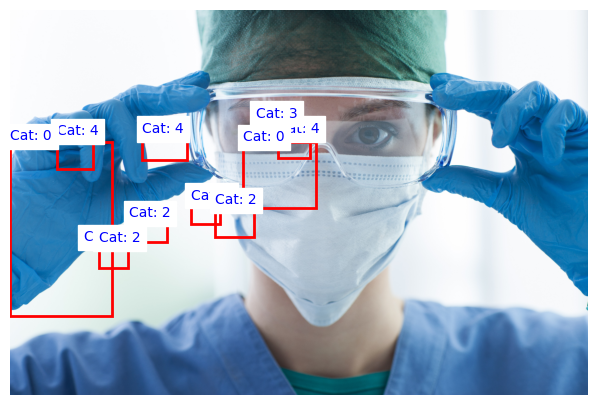

In [7]:
visualize_image_with_bboxes(raw_datasets["train"][5])

In [8]:
processor = AutoImageProcessor.from_pretrained(
        pretrained_model_name_or_path="microsoft/conditional-detr-resnet-50",
        use_fast=False
)

In [24]:
def add_preprocessing(raw_dataset, processor) -> DatasetDict:
    """
    Add preprocessing to the dataset using only the processor.

    Args:
        raw_dataset: The dataset to preprocess.
        processor: The DetrImageProcessor to use for preprocessing.

    Returns:
        The preprocessed dataset.
    """
    datasets = process_to_rgb(raw_dataset)

    # Batch transformation function for both train and validation/test splits
    def transform_batch(examples):
        images = []
        targets = []
        for i in range(len(examples["image"])):  # 使用 "image" 字段
            # 将 PIL 图像转换为 NumPy 数组
            image = examples["image"][i]
            if isinstance(image, Image.Image):
                image = torch.tensor(np.array(image)).permute(2, 0, 1)  # 转换为 [C, H, W]

            # 提取标签信息
            objects = examples["objects"][i]
            bboxes = objects["bbox"]  # 从 "objects" 中提取 "bbox"
            category_ids = objects["category"]  # 从 "objects" 中提取 "category"
            areas = objects["area"]  # 从 "objects" 中提取 "area"

            # 构建 annotations
            annotations = []
            for j in range(len(bboxes)):
                annotation = {
                    "bbox": bboxes[j],
                    "category_id": category_ids[j],
                    "area": areas[j],
                }
                annotations.append(annotation)

            target = {
                "image_id": examples["image_id"][i],  # 使用 "image_id" 字段
                "annotations": annotations,
            }
            images.append(image)
            targets.append(target)

        # 使用处理器进行预处理
        encoding = processor(images=images, annotations=targets, return_tensors="pt")
        return {
            "pixel_values": encoding["pixel_values"],
            "labels": encoding["labels"],
        }

    # Apply the same transformation to all splits (train, validation, test)
    datasets["train"] = datasets["train"].with_transform(transform_batch)
    datasets["validation"] = datasets["validation"].with_transform(transform_batch)
    datasets["test"] = datasets["test"].with_transform(transform_batch)

    return datasets

In [25]:
datasets = add_preprocessing(raw_datasets, processor)


Processing train split with 850 samples:
Finished processing train split.

Processing test split with 29 samples:
Finished processing test split.

Processing validation split with 150 samples:
Finished processing validation split.


In [26]:
print(datasets["train"][5])

{'pixel_values': tensor([[[ 2.2318,  2.2318,  2.2318,  ...,  1.7865,  1.7523,  1.7523],
         [ 2.2318,  2.2318,  2.2318,  ...,  1.7865,  1.7523,  1.7523],
         [ 2.2318,  2.2318,  2.2318,  ...,  1.7865,  1.7523,  1.7523],
         ...,
         [-1.5185, -1.5357, -1.5528,  ..., -1.3644, -1.3644, -1.3644],
         [-1.5185, -1.5357, -1.5528,  ..., -1.3644, -1.3644, -1.3644],
         [-1.4843, -1.5185, -1.5185,  ..., -1.3815, -1.3644, -1.3644]],

        [[ 2.4111,  2.4111,  2.4111,  ...,  2.0784,  2.0434,  2.0434],
         [ 2.4111,  2.4111,  2.4111,  ...,  2.0784,  2.0434,  2.0434],
         [ 2.4111,  2.4111,  2.4111,  ...,  2.0784,  2.0434,  2.0434],
         ...,
         [-0.7927, -0.8102, -0.8277,  ..., -0.5651, -0.5651, -0.5651],
         [-0.7927, -0.8102, -0.8277,  ..., -0.5651, -0.5651, -0.5651],
         [-0.7577, -0.7927, -0.7927,  ..., -0.5826, -0.5651, -0.5651]],

        [[ 2.6226,  2.6226,  2.6226,  ...,  2.3960,  2.3611,  2.3611],
         [ 2.6226,  2.6226, 

In [28]:
visualize_image_with_bboxes(datasets["train"][5])

KeyError: 'image'